## Problem
Forecast daily sales of a product at various stores in various provinces for the next 28 days

## Dataset
### sales_train_validation.csv: historical daily unit sales data per product and store
- id
- item_id : ID of product
- dept_id
- cat_id
- store_id
- state_id
- d_1 to d_1913: unit sales of days 1 through 1913 ( starting from 2011-01-29)

### sell_prices.csv: price of the products sold per store and date
- store_id     
- item_id       
- wm_yr_wk: the id of the week     
- sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week.

### calendar.csv: dates the products are sold
- date: The date (“y-m-d”)
- d: Day number
- wm_yr_wk: The id of the week
- weekday: The type of the day (Saturday, Sunday, …, Friday).
- wday: The id of the weekday, starting from Saturday.
- month
- year
- event_name_1: If the date includes an event, the name of this event.
- event_type_1
- event_name_2: If the date includes a second event, the name of this event.
- event_type_2
- snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP1 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
# Credit: The reduce_mem_usage function has been taken from 
# https://gist.github.com/tkazusa/4d9e26d403c73755edc6b77b5b053a43
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def data_stats(data):
    print('Info: ')
    print(data.info())
    print('\nFirst few rows of the data:')
    print(data.head())
    print('\nShape of the data:')
    print(data.shape)

In [4]:
sales_train_validation_data = pd.read_csv('data/sales_train_validation.csv')
sales_train_validation_data = reduce_mem_usage(sales_train_validation_data)
calendar_data = pd.read_csv('data/calendar.csv')
calendar_data = reduce_mem_usage(calendar_data)
prices_data = pd.read_csv('data/sell_prices.csv')
prices_data = reduce_mem_usage(prices_data)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%
Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%


## sales_train_validation.csv

In [5]:
data_stats(sales_train_validation_data)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.4 MB
None

First few rows of the data:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2    

In [6]:
print('Dept ID types for products:\n')
print(sales_train_validation_data.dept_id.value_counts())

print('\nCategory ID types for products:\n')
print(sales_train_validation_data.cat_id.value_counts())

print('\nStore ID types for products:\n')
print(sales_train_validation_data.store_id.value_counts())

Dept ID types for products:

FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64

Category ID types for products:

FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64

Store ID types for products:

WI_3    3049
WI_2    3049
WI_1    3049
TX_3    3049
TX_2    3049
TX_1    3049
CA_4    3049
CA_3    3049
CA_2    3049
CA_1    3049
Name: store_id, dtype: int64


In [26]:
zero_counts = (sales_train_validation_data.iloc[:, 6:] == 0).sum(axis=1)
print(type(zero_counts))
zero_counts

<class 'pandas.core.series.Series'>


0        1492
1        1511
2        1697
3         617
4         950
5        1261
6        1559
7         535
8        1033
9         996
10       1784
11       1315
12       1523
13        852
14        373
15        393
16        963
17       1834
18        995
19       1422
20       1155
21       1396
22        896
23       1573
24       1360
25       1894
26       1650
27       1068
28        631
29        930
         ... 
30460    1763
30461    1602
30462     773
30463     757
30464    1300
30465    1489
30466     119
30467     602
30468    1750
30469     364
30470     412
30471     834
30472    1427
30473     626
30474     742
30475    1782
30476     517
30477    1678
30478     832
30479    1223
30480     881
30481     649
30482     532
30483    1267
30484     485
30485    1390
30486    1433
30487    1030
30488    1557
30489    1416
Length: 30490, dtype: int64

In [23]:
(zero_counts[zero_counts > np.round(1913/2)]).shape

(23916,)

Out of 30490 rows, 23916 (i.e. 78% of) rows have more than 50% 0 values for unit sales

In [34]:
null_counts = (sales_train_validation_data.iloc[:, 6:].isnull()).sum(axis=1)
null_counts.sum()

0

We find that there are no null values for columns d_1 to d_1913

In [67]:
unique_elements, counts_elements = np.unique(sales_train_validation_data.iloc[:, 6:].values, return_counts=True)
# figure = plt.figure(figsize=(16, 12))
# plt.plot(unique_elements, counts_elements)

In [66]:
print('Units sold vs number of times (across all products)')
print(list(zip(unique_elements, counts_elements)))

Units sold vs number of times (across all products)
[(0, 39777094), (1, 7753194), (2, 3894493), (3, 2098127), (4, 1279524), (5, 812653), (6, 565775), (7, 393514), (8, 300120), (9, 222644), (10, 178683), (11, 140168), (12, 121888), (13, 94337), (14, 79377), (15, 66900), (16, 57084), (17, 47969), (18, 41851), (19, 36027), (20, 32359), (21, 27965), (22, 24860), (23, 21980), (24, 21865), (25, 18099), (26, 16176), (27, 14571), (28, 13200), (29, 11763), (30, 10844), (31, 9930), (32, 9035), (33, 8234), (34, 7603), (35, 7110), (36, 6723), (37, 6033), (38, 5557), (39, 4955), (40, 4893), (41, 4393), (42, 4246), (43, 3827), (44, 3601), (45, 3311), (46, 3158), (47, 2857), (48, 3038), (49, 2691), (50, 2467), (51, 2282), (52, 2277), (53, 1993), (54, 1931), (55, 1903), (56, 1786), (57, 1684), (58, 1593), (59, 1418), (60, 1436), (61, 1301), (62, 1169), (63, 1081), (64, 1079), (65, 1039), (66, 1000), (67, 978), (68, 852), (69, 872), (70, 803), (71, 746), (72, 758), (73, 716), (74, 650), (75, 612), (76,

We find that 0 units were sold for a lot of products, next 1 unit was sold for a lot of products etc.

We also find that eg 693 units were sold once, 709 units were sold twice, 763 units were sold once, etc; we can investigate what those products/categories were to see what those products were for which there were so many units, if they were seasonal products, etc.

### Note: TODO Later

In [7]:
null_counts_categorical_cols = (sales_train_validation_data.iloc[:, :5].isnull()).sum(axis=1)
null_counts_categorical_cols.sum()

0

We find that id, item_id, dept_id, store_id, state_id, cat_id columns don't contain any null values, which is good

In [8]:
# with np.printoptions(threshold=np.inf):    
#     data = sales_train_validation_data.iloc[:, 6:].values.mean(axis=1)
#     print(data)
mean_units_solid = np.mean(sales_train_validation_data.iloc[:, 6:].values, axis=1)
print('Mean units sold per product per store: {}'.format(mean_units_solid))

median_units_solid = np.median(sales_train_validation_data.iloc[:, 6:].values, axis=1)
print('Median units sold per product per store: {}'.format(median_units_solid))

Mean units sold per product per store: [0.31364349 0.2577104  0.15054888 ... 0.89492943 0.36696289 0.69472033]
Median units sold per product per store: [0. 0. 0. ... 0. 0. 0.]


## calendar.csv

In [9]:
data_stats(calendar_data)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null category
wm_yr_wk        1969 non-null int16
weekday         1969 non-null category
wday            1969 non-null int8
month           1969 non-null int8
year            1969 non-null int16
d               1969 non-null category
event_name_1    162 non-null category
event_type_1    162 non-null category
event_name_2    5 non-null category
event_type_2    5 non-null category
snap_CA         1969 non-null int8
snap_TX         1969 non-null int8
snap_WI         1969 non-null int8
dtypes: category(7), int16(2), int8(5)
memory usage: 227.8 KB
None

First few rows of the data:
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011

In [10]:
print('event_name_1 types for products:\n')
print(calendar_data.event_name_1.value_counts())

print('\nevent_type_1 types for products:\n')
print(calendar_data.event_type_1.value_counts())

print('\nevent_name_2 types for products:\n')
print(calendar_data.event_name_2.value_counts())

print('\nevent_type_2 types for products:\n')
print(calendar_data.event_type_2.value_counts())

event_name_1 types for products:

MemorialDay            6
Mother's day           6
LentStart              6
SuperBowl              6
StPatricksDay          6
Ramadan starts         6
Purim End              6
PresidentsDay          6
Pesach End             6
LentWeek2              6
ValentinesDay          6
NBAFinalsStart         6
NBAFinalsEnd           6
Eid al-Fitr            5
ColumbusDay            5
Easter                 5
Halloween              5
Cinco De Mayo          5
Christmas              5
EidAlAdha              5
VeteransDay            5
IndependenceDay        5
LaborDay               5
MartinLutherKingDay    5
NewYear                5
OrthodoxChristmas      5
OrthodoxEaster         5
Thanksgiving           5
Chanukah End           5
Father's day           4
Name: event_name_1, dtype: int64

event_type_1 types for products:

Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64

event_name_2 types for products:

Father's day    

## sell_prices.csv

In [11]:
data_stats(prices_data)

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      category
item_id       category
wm_yr_wk      int16
sell_price    float16
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB
None

First few rows of the data:
  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

Shape of the data:
(6841121, 4)


In [111]:
# null_counts_price_cols = (prices_data[prices_data.sell_price.isnull()])
# null_counts_price_cols.sum()
prices_data.sell_price.isnull().sum()

0

sell_price column doesn't contain any null values

In [114]:
(prices_data.sell_price == 0).sum()

0

sell_price column doesn't contain any zero values

## Data preprocessing + joining

In [5]:
d_colnames = []
for i in range(1, 1914):
    d_colnames.append('d_'+str(i))

In [6]:
sales_train_validation_data_new = pd.melt(sales_train_validation_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')

In [7]:
sales_train_validation_data_new['day_number'] = \
    sales_train_validation_data_new['day_number'].apply(lambda x: int(x[2:]))

In [8]:
sales_train_validation_data_new = reduce_mem_usage(sales_train_validation_data_new)

Memory usage of dataframe is 1002.84 MB
Memory usage after optimization is: 669.09 MB
Decreased by 33.3%


In [16]:
sales_train_validation_data_new

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,1,0


In [9]:
calendar_data['d'] = \
    calendar_data['d'].apply(lambda x: int(x[2:]))
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
merged_df = sales_train_validation_data_new.merge(calendar_data, left_on='day_number', right_on='d', how='left')
merged_df = reduce_mem_usage(merged_df)
merged_df.head()

Memory usage of dataframe is 2449.29 MB
Memory usage after optimization is: 2115.63 MB
Decreased by 13.6%


,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0


We test if it's merged properly:

In [44]:
merged_df.shape

(58327370, 22)

In [45]:
sales_train_validation_data_new.shape

(58327370, 8)

In [11]:
# delete old dataframes to free up memory
del calendar_data
del sales_train_validation_data
del sales_train_validation_data_new

In [12]:
gc.collect() # Garbage collector

68

In [48]:
merged_df.memory_usage

<bound method DataFrame.memory_usage of                                      id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
5         HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES   
6         HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES   
7         HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES   
8         HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES   
9         HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES   
10        HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES   
11        HOBBIES_1_012_

In [26]:
prices_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [13]:
df = merged_df.merge(
    prices_data, left_on=['store_id', 'item_id', 'wm_yr_wk'],
    right_on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2226.88 MB
Memory usage after optimization is: 2226.88 MB
Decreased by 0.0%


,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN


In [14]:
del merged_df
del prices_data
gc.collect()

48

In [29]:
# Test if df has been joined properly
df[df.wm_yr_wk == 11325]

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
27319040,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,9.578125
27319041,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,897,1,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,3.970703
27319042,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,NaN
27319043,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,4.640625
27319044,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,897,2,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,3.080078
27319045,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,1.000000
27319046,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,7.878906
27319047,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,897,9,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,0.459961
27319048,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,1.769531
27319049,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,897,0,2013-07-13,11325,...,2013,897,NaN,NaN,NaN,NaN,0,1,0,2.970703


In [51]:
# Save the joined dataframe to a CSV
df.to_csv('data/all_data.csv', index=False)

In [52]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'day_number', 'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday',
       'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

Unique identifiers and static features: 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'
Time varying features: 'day_number', 'units_sold', 'date', 'wm_yr_wk', 'weekday', 'wday',
       'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'

In [55]:
df[['weekday', 'wday']].sample(n=20)

,weekday,wday
36680845,Friday,7
6326332,Wednesday,5
32435230,Friday,7
56494296,Wednesday,5
4888804,Friday,7
34112109,Thursday,6
37859002,Monday,3
27909673,Thursday,6
5147018,Saturday,1
40163413,Sunday,2


Both columns are similar (wday corresponds to number signalling weekday) so we can drop 1 - we drop wday
We can drop d also as d is the same as day_number
We drop wm_yr_wk as we don't need the week ID, we will generate another feature which gives us the week
number of the year, which might be more useful

In [15]:
df.drop(['wday', 'd', 'wm_yr_wk'], inplace=True, axis=1)

In [16]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4


## Data Visualization

Visualizing Units sold according to event_name_1

In [60]:
# avg daily units sold per event
avg_units_sold_event1_days = df[~df.event_name_1.isnull()] \
                            [['event_name_1', 'day_number', 'units_sold']] \
                            .groupby('event_name_1') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
# rename columns
avg_units_sold_event1_days.columns = ['event_name_1', 'avg_units_sold']

# avf daily units sold on no-event days
units_sold_no_event_days = df[(df.event_name_1.isnull()) & (df.event_name_2.isnull())][['day_number', 'units_sold']] 
no_event_daily_avg_units = units_sold_no_event_days['units_sold'].sum() / \
                                units_sold_no_event_days['day_number'].nunique()


# create a 1-row dataframe with the no-event information and concatenate it with the previous dataframe
row_df = pd.DataFrame({'event_name_1': 'No Event', 'avg_units_sold': [no_event_daily_avg_units]})
avg_units_sold_event1_days = pd.concat([avg_units_sold_event1_days, row_df], ignore_index=True)

avg_units_sold_event1_days

,event_name_1,avg_units_sold
0,Chanukah End,33426.800000
1,Christmas,15.600000
2,Cinco De Mayo,32823.500000
3,ColumbusDay,35164.800000
4,Easter,39517.600000
5,Eid al-Fitr,35267.600000
6,EidAlAdha,34504.000000
7,Father's day,36562.000000
8,Halloween,30059.400000
9,IndependenceDay,33710.800000


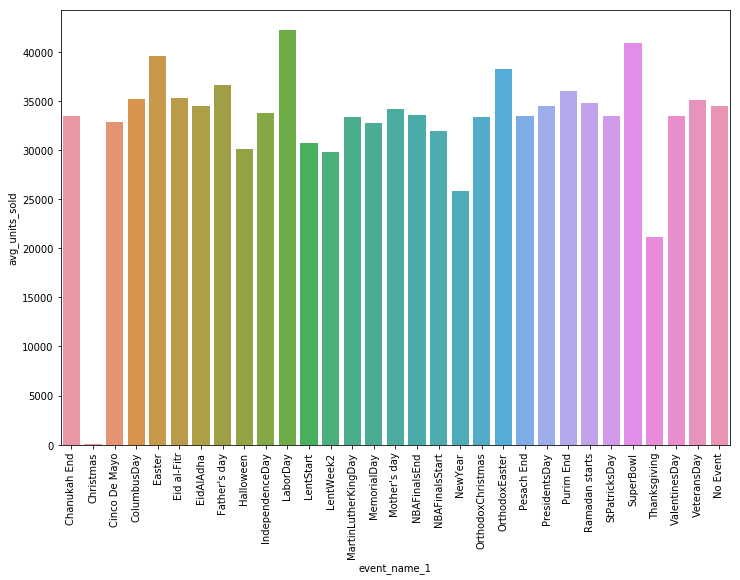

In [58]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="event_name_1", y="avg_units_sold", data=avg_units_sold_event1_days)
for item in ax.get_xticklabels():
    item.set_rotation(90)

We notice that, for event_name_1, Christmas has almost no sale, Thanksgiving has low sale, and Labour Day has the highest sale.

In [63]:
# avg daily units sold per event
avg_units_sold_event2_days = df[~df.event_name_2.isnull()] \
                            [['event_name_2', 'day_number', 'units_sold']] \
                            .groupby('event_name_2') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()


# rename columns
avg_units_sold_event2_days.columns = ['event_name_2', 'avg_units_sold']

row_df = pd.DataFrame({'event_name_2':'No Event', 'avg_units_sold': [no_event_daily_avg_units]})
avg_units_sold_event2_days = pd.concat([avg_units_sold_event2_days, row_df], ignore_index=True)

avg_units_sold_event2_days

,event_name_2,avg_units_sold
0,Cinco De Mayo,43203.000000
1,Easter,24018.000000
2,Father's day,42494.000000
3,OrthodoxEaster,38934.000000
4,No Event,34489.207504


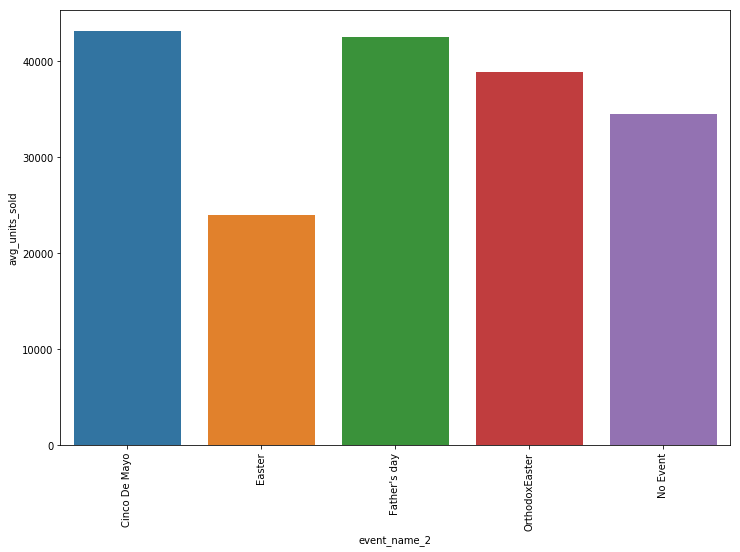

In [64]:
figure = plt.figure(figsize=(12,8))
ax = sns.barplot(x="event_name_2", y="avg_units_sold", data=avg_units_sold_event2_days)
for item in ax.get_xticklabels():
    item.set_rotation(90)

We notice that, for event_name_2, Easter has lower sales compared to the others.

## TODO

- units sold and snap values
- units sold and stores
- (rolling mean?) units sold vs time according to provinces
- units sold vs department
- products which sold an abnormal number of high units (distplot?)

In [4]:
# row1= sales_train_validation_data.loc[0]
# x = list(range(1,1914))
# y = list(row1[6:])
# plt.figure(figsize=(20,8))
# plt.plot(x, y)

In [5]:
# def plot_rolling_mean(rownum):
#     row1= sales_train_validation_data.iloc[rownum:rownum+1, :]
#     x = list(range(1,1914)) # no of d columns

#     y = row1.iloc[0, 6:].rolling(50, min_periods=1).mean().values # d column rolling mean values
#     plt.figure(figsize=(10,8))
#     plt.plot(x, y)

# plot_rolling_mean(0)

In [6]:
# plot_rolling_mean(8)
# # Seasonality

creation of training and target set → write down approach: how to create target variable (eg moving windows over time looking at previous sales), how to create training set, how will you divide data intro training, validation and test set (eg might want to do time-based split, should not have random split, explore what approaches people are following for time varying longitudinal split)

Do cross-product analysis

Try k-means clustering and see what results you get